In [258]:
import random
import os, sys
import numpy as np
import pandas as pd
from scipy.signal import medfilt
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from preprocess import *
from stats_util import *
from graph_util import *
from outliers_util import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sim_dir = os.path.join('/'.join(sim_dir.split('/')[:-1]), 'top_sim_new_new')
print "Using directory:", sim_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using directory: /Users/Lisa/Research/repos/socialTrajectory/top_sim_new_new


# Loading structures

In [259]:
year_qs = ['2012_1', '2013_1', '2014_1']
field_ys = ['pself', 'pother', 'token']
top_sims = {}
for year_q in year_qs:
    top_sims_year_q = load_top_sims(year_q, sim_dir=sim_dir)
    preprocess_top_sims(top_sims_year_q)
    top_sims.update(top_sims_year_q)
print len(top_sims.keys())

loaded top sims from /Users/Lisa/Research/repos/socialTrajectory/top_sim_new_new/2012_1.csv
Factor for norming steps 1500
loaded top sims from /Users/Lisa/Research/repos/socialTrajectory/top_sim_new_new/2013_1.csv
Factor for norming steps 1500
loaded top sims from /Users/Lisa/Research/repos/socialTrajectory/top_sim_new_new/2014_1.csv
Factor for norming steps 1500
1419


## Get token names

num tokens 1965
num unique fnames 1965
Small files (count 60)
Wrote pruned items to tokens/pruned_tokens_2012_1.csv
Wrote pruned items to tokens/pruned_tokens_2013_1.csv
Wrote pruned items to tokens/pruned_tokens_2014_1.csv
pruned number 1905
Mean tokens 1154.97847769 (stdev 396.87817876)
Mean lines 340.739632546 (stdev 112.130320829)


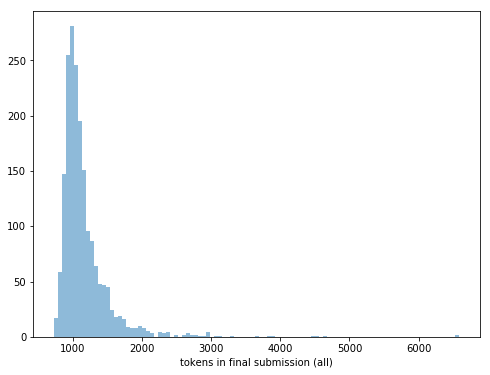

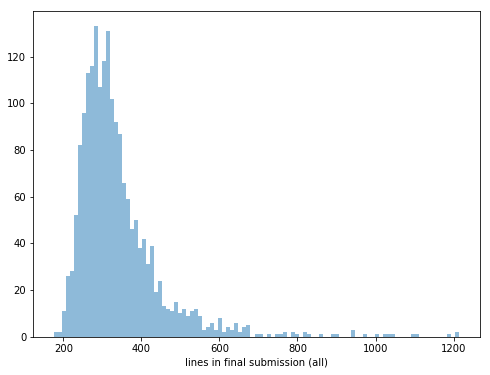

In [260]:
fnames, token_lens, line_lens = [], [], []
for year_q in year_qs:
    with open(os.path.join('tokens', 'tokens_%s.csv' % year_q), 'r') as f:
        lines = f.readlines()
    year_q_fnames, year_q_token_lens, year_q_line_lens = zip(*([line.strip().split(',') for line in lines]))
    fnames += year_q_fnames
    token_lens += year_q_token_lens
    line_lens += year_q_line_lens
token_lens = map(int, token_lens)
line_lens = map(int, line_lens)
print "num tokens", len(token_lens)
print "num unique fnames", len(list(set(fnames)))

TOKEN_THRESH = 700
small_ones = [fnames[i] for i, _ in enumerate(token_lens) if token_lens[i] <= TOKEN_THRESH]
print "Small files (count {})".format(len(small_ones))
#print ' '.join(small_ones)

# NOTE: fixing at 700 as the threshold for a complete breakout solution.
keep_inds = [i for i, _ in enumerate(token_lens) if token_lens[i] > TOKEN_THRESH]
zipped_ver = zip(fnames, token_lens, line_lens)
fnames, token_lens, line_lens = zip(*([zipped_ver[i] for i in keep_inds]))
zipped_ver = zip(fnames, token_lens, line_lens)
for year_q in year_qs:
    year_items = [tup for tup in zipped_ver if year_q in tup[0]]
    with open(os.path.join('tokens', 'pruned_tokens_%s.csv' % year_q), 'w') as f:
        f.write('\n'.join([','.join(map(str, tup)) for tup in year_items]))
        print "Wrote pruned items to", f.name
print "pruned number", len(token_lens)
print "Mean tokens {} (stdev {})".format(np.mean(token_lens), np.std(token_lens))
print "Mean lines {} (stdev {})".format(np.mean(line_lens), np.std(line_lens))

plt.figure(figsize=(8,6))
ax = plt.gca()
vals, bins, _ = ax.hist(token_lens, bins=101, alpha=0.5,align='mid')
ax.set_xlabel('tokens in final submission (all)')
fig.suptitle('PMF of total tokens in final submission')
plt.show()

plt.figure(figsize=(8,6))
ax = plt.gca()
vals, bins, _ =ax.hist(line_lens, bins=101, alpha=0.5,align='mid')
ax.set_xlabel('lines in final submission (all)')
fig.suptitle('PMF of total lines in final submission')
plt.show()
#print ','.join(['%.2f' % item for item in bins.tolist()])
#print vals.tolist()

small_ones = [(fnames[i], token_lens[i], line_lens[i]) for i, _ in enumerate(token_lens) if token_lens[i] <= 800]
small_ones.sort(key=lambda (fname, token_len, line_len): token_len)



## Graph 95th percentile

In [242]:
norm_step_x, interp_y = get_percentiles(top_sims, 'norm_step', field_ys, max_factor=largest_factor, perc=95)
x, interp_whisk = get_upper_whiskers(top_sims, 'norm_step', field_ys, max_factor=largest_factor, factor=1.5)

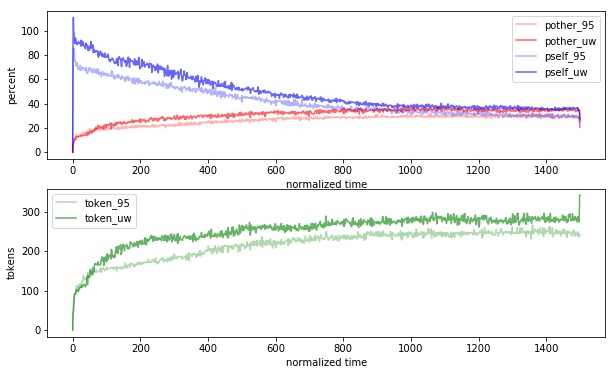

In [243]:
fig, axs = plt.subplots(2,1, figsize=(10, 6))
plot_outlier_lines(norm_step_x, interp_y, interp_whisk, axs)
for ax in axs:
    ax.legend()

axs[0].set_ylabel('percent')
axs[1].set_ylabel('tokens')
axs[0].set_xlabel('normalized time')
axs[1].set_xlabel('normalized time')
plt.show()

## Get outliers

In [268]:
from outliers_util import *
from stats_util import *
from preprocess import *
import stats_util
sim_dir = 'top_sim_new_new'
top_sims = {}
for year_q in year_qs:
    top_sims_year_q = load_top_sims(year_q, sim_dir=sim_dir)
    preprocess_top_sims(top_sims_year_q)
    top_sims.update(top_sims_year_q)
top_sims_arr = top_sims_to_array(top_sims, 'norm_step', field_ys)
max_tokens, max_pothers = get_max_token_pother(top_sims_arr)
headers, all_items = get_avg_and_max_full(top_sims_arr, ['pother', 'token'])
pother_ind, token_ind, fpath_ind = map(get_header_ind, ['pother', 'token', 'fpath'])
pself_ind, other_ind = get_header_ind('pself'), get_header_ind('other')
new_items = []
for uname, pother_po, pother_t, token_po, token_t in all_items:
    sims_uname = top_sims[uname]
    pother_sims = filter(lambda item: float(item[pother_ind]) == pother_po and float(item[token_ind]) == pother_t, sims_uname)
    pother_first_sim = pother_sims[0]
    pother_fname = pother_first_sim[fpath_ind]
    pother_ps = pother_first_sim[pself_ind]
    pother_other = pother_first_sim[other_ind]
    print "{} (other {}): pother_po {}, pother_t {}, pself {}. self len {}, other len {}".format(
        uname, pother_other, pother_po, pother_t, pother_ps,
        100*float(pother_t)/float(pother_ps), 100*float(pother_t)/float(pother_po))
    
    token_sims = filter(lambda item: float(item[pother_ind]) == token_po and float(item[token_ind]) == token_t, sims_uname)
    token_first_sim = token_sims[0]
    token_fname = token_first_sim[fpath_ind]
    new_items.append((uname, pother_po, pother_t, pother_fname, token_po, token_t, token_fname))
new_headers = headers[:3] + ['pother_fname'] + headers[3:] + ['token_fname']
all_items, headers = new_items, new_headers

with open(os.path.join(sim_dir, 'all_maxes_new.csv'), 'w') as f:
    f.write('{}\n'.format(','.join(headers)))
    f.write('\n'.join([','.join(map(str, item)) for item in all_items]))
    print "Wrote csv to", f.name

loaded top sims from top_sim_new_new/2012_1.csv
Factor for norming steps 1500
loaded top sims from top_sim_new_new/2013_1.csv
Factor for norming steps 1500
loaded top sims from top_sim_new_new/2014_1.csv
Factor for norming steps 1500
2012010000 (other 2012010231_Breakout): pother_po 19.98, pother_t 181.0, pself 19.87. self len 910.920986412, other len 905.905905906
2012010002 (other 2012010259_Breakout): pother_po 25.24, pother_t 258.0, pself 29.76. self len 866.935483871, other len 1022.18700475
2012010003 (other 2012010067_Breakout): pother_po 21.1, pother_t 177.0, pself 23.26. self len 760.963026655, other len 838.862559242
2012010004 (other 2012010398_Breakout): pother_po 21.28, pother_t 150.0, pself 50.85. self len 294.985250737, other len 704.887218045
2012010005 (other 2012010022_Breakout): pother_po 20.89, pother_t 173.0, pself 27.5. self len 629.090909091, other len 828.147438966
2012010006 (other 2012010110_Breakout): pother_po 18.47, pother_t 116.0, pself 18.65. self len 621

# Compare the different outliers

read csv from top_sim/all_maxes.csv
read csv from top_sim_new/all_maxes_new.csv
read csv from top_sim_new_new/all_maxes_new.csv
token_t of old (token): 95th: 327.0, 1.5IQR: 320.5
best loss (mu: 165.041825105, beta: 44.7294149995): 0.00117631178288
token_po of old (pother): 95th: 37.1955, 1.5IQR: 39.895
best loss (mu: 10.0652598074, beta: 7.00976185272): 0.0221521115378
token_t of new (token): 95th: 325.0, 1.5IQR: 305.0
best loss (mu: 160.945113287, beta: 42.9079223113): 0.00129608069629
token_po of new (pother): 95th: 50.0275, 1.5IQR: 40.00375
best loss (mu: 16.3845366064, beta: 6.37817854052): 0.0137071237198
token_t of new_new (token): 95th: 323.0, 1.5IQR: 305.0
best loss (mu: 162.154397614, beta: 42.9344668762): 0.00129233376674
token_po of new_new (pother): 95th: 38.875, 1.5IQR: 39.2275
best loss (mu: 15.5752280351, beta: 6.8061870491): 0.017723761727


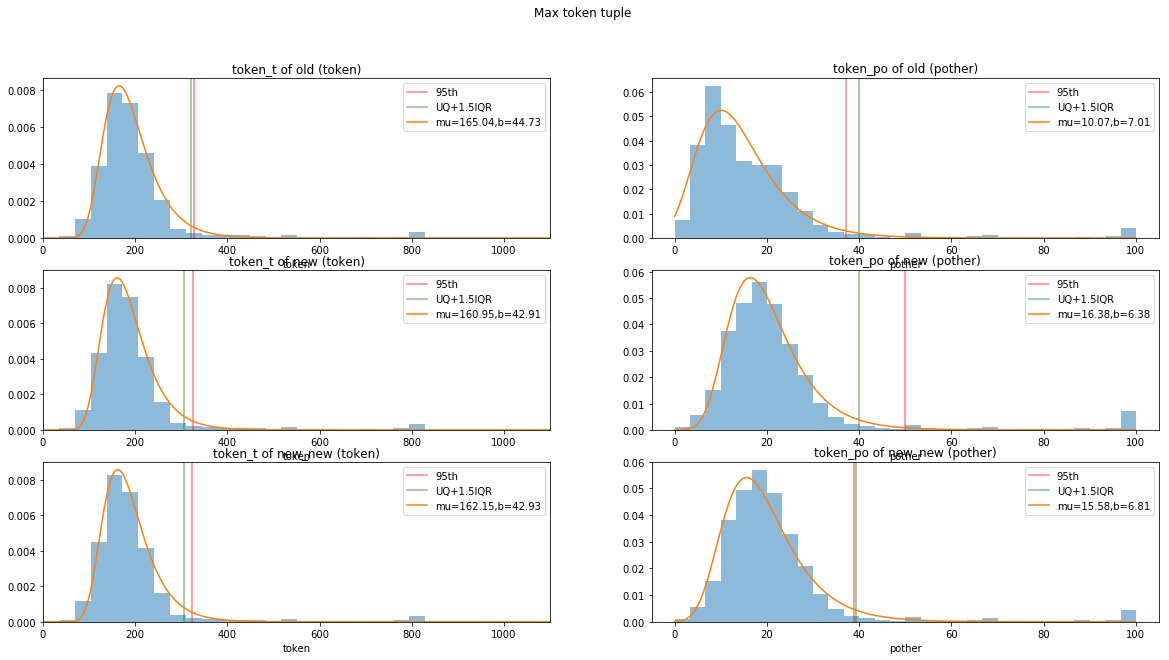

pother_t of old (token): 95th: 310.35, 1.5IQR: 304.0
best loss (mu: 142.710486138, beta: 49.1714158311): 0.00202823552916
pother_po of old (pother): 95th: 39.992, 1.5IQR: 39.1875
best loss (mu: 16.0849647012, beta: 6.26138802745): 0.0126119810756
pother_t of new (token): 95th: 323.0, 1.5IQR: 302.0
best loss (mu: 150.889290845, beta: 46.1631113086): 0.00211752761565
pother_po of new (pother): 95th: 66.67, 1.5IQR: 42.90875
best loss (mu: 18.7207460955, beta: 6.00637179894): 0.0142669258207
pother_t of new_new (token): 95th: 323.0, 1.5IQR: 302.0
best loss (mu: 150.155303528, beta: 46.0334825807): 0.00211681231831
pother_po of new_new (pother): 95th: 66.67, 1.5IQR: 42.90875
best loss (mu: 18.2683004864, beta: 6.73847229738): 0.0172496014292


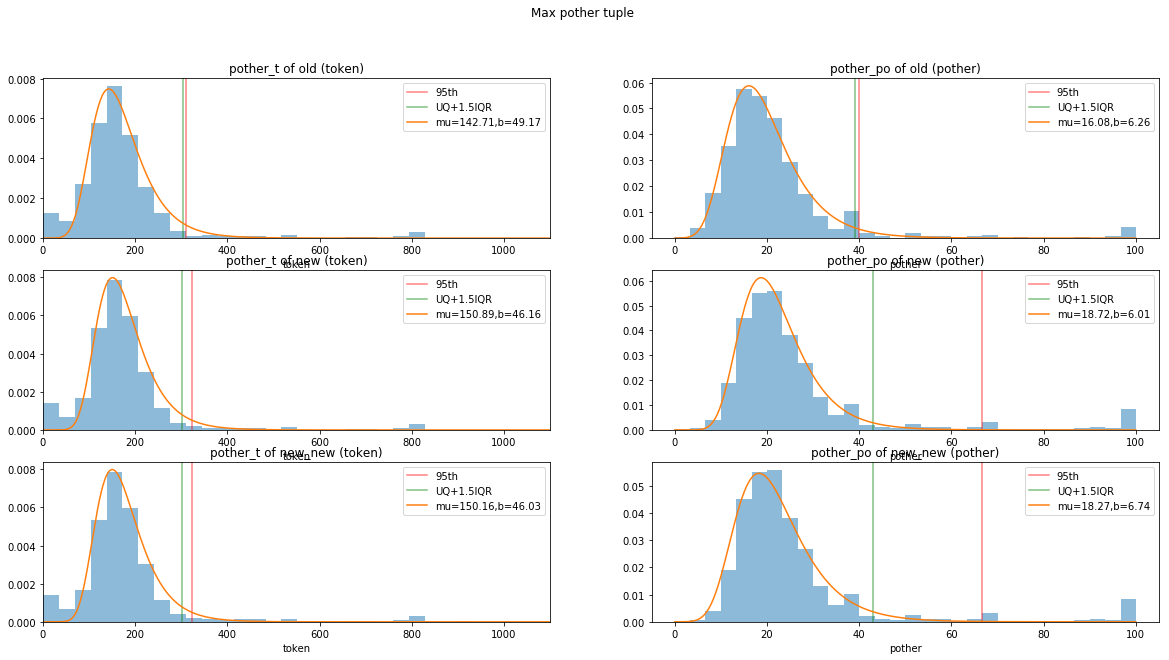

In [247]:
mu_po, beta_po = 17.5, 4.7 # location and scale # GUMBEL
mu_token, beta_to = 50, 5
mu_range_po = [4.7, 20]

def gumbel_fn(x, mu, beta):
    return (1/beta)*np.exp(-(x - mu)/beta) * np.exp( -np.exp( -(x - mu) /beta) )

def plot_gumbel(ax, vals, bin_range, mu, beta, nitems=1000):
    ulim = max(bin_range)
    x = np.linspace(0, ulim, num=nitems)
    best_mu, best_beta = gumbel_search(vals, bin_range, mu, beta)
    y = gumbel_fn(x, best_mu, best_beta)
    ax.plot(x, y,label='mu=%.2f,b=%.2f'%(best_mu, best_beta))
    return x, y

def get_gumbel_ranges(mu, beta, iters=30):
    # use pother range
    if mu >= mu_range_po[0] and mu <= mu_range_po[1]:
        return np.random.uniform(4.7, 20, iters).tolist(), \
                    np.random.uniform(3, 10, iters).tolist()
    # use token range
    return np.random.uniform(100, 200, 50).tolist(), \
               np.random.uniform(30, 60, 50).tolist()
    
def gumbel_search(vals, bin_range, best_mu, best_beta, iters=10):
    mu_range, beta_range = get_gumbel_ranges(best_mu, best_beta,iters=iters) # random
    i = 0
    mp_range = np.array(bin_range)[:-1] + (bin_range[1]-bin_range[0])/2 # midpoint of each bar
    preds = gumbel_fn(mp_range, best_mu, best_beta)
    best_loss = np.linalg.norm(preds - vals)
    for mu in mu_range:
        for beta in beta_range:
            preds = gumbel_fn(mp_range, mu, beta)
            loss = np.linalg.norm(preds - vals)
            if loss < best_loss:
                best_loss = loss
                best_mu, best_beta = mu, beta
                #print "new loss (iter {}) (mu: {}, beta: {}): {}".format(i, best_mu, best_beta, best_loss)
            i += 1 
    print "best loss (mu: {}, beta: {}): {}".format(best_mu, best_beta, best_loss)
    return best_mu, best_beta

max_headers = ['uname', 'pother_po', 'pother_t', 'pother_fname', 'token_po', 'token_t', 'token_fname']
def load_maxes(sim_dir):
    max_f = os.path.join(sim_dir, 'all_maxes.csv')
    if 'new' in sim_dir:
        max_f = os.path.join(sim_dir, 'all_maxes_new.csv')
    with open(max_f, 'r') as f:
        f.readline() # headers
        lines = f.readlines()
        max_items = [line.strip().split(',') for line in lines]
        print "read csv from", f.name
    return max_items

def get_max_header_ind(field):
    return max_headers.index(field)

max_items = load_maxes('top_sim')
max_items_new = load_maxes('top_sim_new')
max_items_new_new = load_maxes('top_sim_new_new')

def graph_histogram(ax, title, field, arr, bins=30):
    if field == 'pother':
        bin_range = np.linspace(0, 100, num=bins+1).tolist()
        mu, beta = mu_po, beta_po
    elif field == 'token':
        bin_range = np.linspace(0, 1000, num=bins).tolist() + [2000] # max is 1912 or something
        mu, beta = mu_token, beta_to
    vals, bins, _ = ax.hist(arr, bins=bin_range, alpha=0.5,normed=1,align='mid')
    ax.set_xlabel(field)
    title_str = '%s (%s)' % (title, field)
    ax.set_title(title_str)
    line_95 = np.percentile(arr, 95)
    ax.axvline(x=line_95, c='r', alpha=0.5,label='95th')
    line_15iqr = np.percentile(arr, 75) + 1.5*(np.percentile(arr,75) - np.percentile(arr,25))
    print '%s: 95th: %s, 1.5IQR: %s' % (title_str, line_95, line_15iqr)
    ax.axvline(x=line_15iqr,c='g', alpha=0.5,label='UQ+1.5IQR')
    
    plot_gumbel(ax, vals, bin_range, mu, beta)
    if field == 'token':
        ax.set_xlim((min(bin_range), 1100))
    ax.legend()
    return vals, bins

def get_tup_arr(max_list, use_token=False):
    str_po, str_t = 'pother_po', 'pother_t'
    if use_token:
        str_po, str_t = 'token_po', 'token_t'
    ind_po, ind_t = get_max_header_ind(str_po), get_max_header_ind(str_t)
    return np.array([(float(item[ind_po]), float(item[ind_t])) for item in max_list])

token_arr = get_tup_arr(max_items, use_token=True)
token_arr_new = get_tup_arr(max_items_new, use_token=True)
token_arr_new_new = get_tup_arr(max_items_new_new, use_token=True)

fig, axs = plt.subplots(3,2, figsize=(20, 10))
old_token_t_hist, token_bins = graph_histogram(axs[0,0], 'token_t of old', 'token', token_arr[:,1], bins=30)
old_token_po_hist, pother_bins = graph_histogram(axs[0,1], 'token_po of old', 'pother', token_arr[:,0], bins=30)
new_token_t_hist, _ = graph_histogram(axs[1,0], 'token_t of new', 'token', token_arr_new[:,1], bins=30)
new_token_po_hist, _ = graph_histogram(axs[1,1], 'token_po of new', 'pother', token_arr_new[:,0], bins=30)
new_new_token_t_hist, _ = graph_histogram(axs[2,0], 'token_t of new_new', 'token', token_arr_new_new[:,1], bins=30)
new_new_token_po_hist, _ = graph_histogram(axs[2,1], 'token_po of new_new', 'pother', token_arr_new_new[:,0], bins=30)
#    print vals.tolist()
#    print ','.join(['%.2f' % item for item in bins.tolist()])
fig.suptitle('Max token tuple')
plt.show()

pother_arr = get_tup_arr(max_items, use_token=False)
pother_arr_new = get_tup_arr(max_items_new, use_token=False)
pother_arr_new_new = get_tup_arr(max_items_new_new, use_token=False)
fig, axs = plt.subplots(3,2, figsize=(20, 10))
old_pother_t_hist, _ = graph_histogram(axs[0,0], 'pother_t of old', 'token', pother_arr[:,1], bins=30)
old_pother_po_hist, _ = graph_histogram(axs[0,1], 'pother_po of old', 'pother', pother_arr[:,0], bins=30)
new_pother_t_hist, _ = graph_histogram(axs[1,0], 'pother_t of new', 'token', pother_arr_new[:,1], bins=30)
new_pother_po_hist, _ = graph_histogram(axs[1,1], 'pother_po of new', 'pother', pother_arr_new[:,0], bins=30)
new_new_pother_t_hist, _ = graph_histogram(axs[2,0], 'pother_t of new_new', 'token', pother_arr_new[:,1], bins=30)
new_new_pother_po_hist, _ = graph_histogram(axs[2,1], 'pother_po of new_new', 'pother', pother_arr_new[:,0], bins=30)
#    print vals.tolist()
#    print ','.join(['%.2f' % item for item in bins.tolist()])
fig.suptitle('Max pother tuple')
plt.show()

# No need to hack

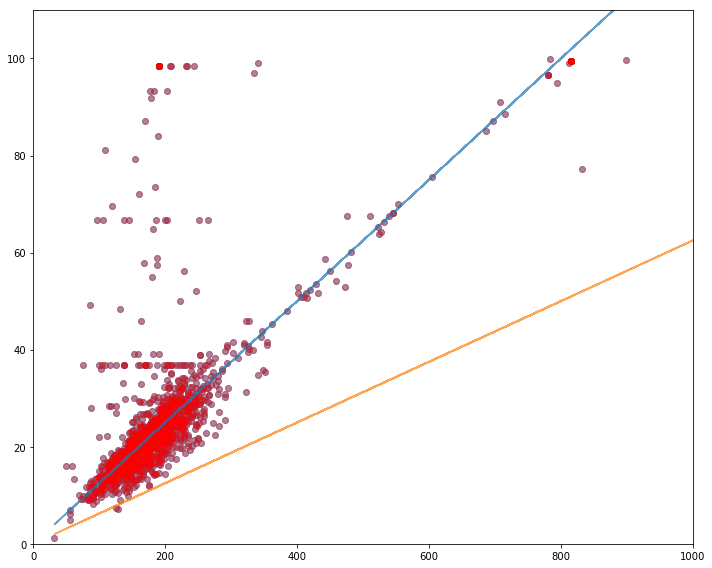

In [256]:
max_tokens, max_pothers = get_max_token_pother(top_sims_arr)
fig = plt.figure()
axs = plt.gca()
desired_slope = 50./400
axs.scatter(max_tokens, max_pothers, alpha=0.5)
axs.plot(max_tokens, desired_slope*max_tokens, alpha=0.7)
axs.plot(max_tokens, 0.5*desired_slope*max_tokens, alpha=0.7)

err = 10
def adjust_slopes(tokens, pothers):
    new_tokens, new_pothers = np.array(tokens), np.array(pothers)
    desired_resid = np.abs(pothers - tokens*desired_slope)
    double_resid = np.abs(pothers - tokens*0.5*desired_slope)
    use_double = err < desired_resid - double_resid # double resid is smaller by an error
    new_tokens[use_double] = tokens[use_double]/2
    return new_tokens, new_pothers
old_tokens, old_pothers = max_tokens, max_pothers
#new_tokens, new_pothers = adjust_slopes(old_tokens, old_pothers)
new_tokens, new_pothers = old_tokens, old_pothers
axs.scatter(new_tokens, new_pothers, alpha=0.3, c='r')

axs.set_xlim((0, 1000))
axs.set_ylim((0, 110))
fig.tight_layout()
max_tokens, max_pothers = new_tokens, new_pothers

{'boxes': [<matplotlib.lines.Line2D at 0x12c81cf90>],
 'caps': [<matplotlib.lines.Line2D at 0x12c82ced0>,
 'fliers': [<matplotlib.lines.Line2D at 0x12c845210>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x12c838b90>],
 'whiskers': [<matplotlib.lines.Line2D at 0x128abb5d0>,
  <matplotlib.lines.Line2D at 0x12c82c890>]}

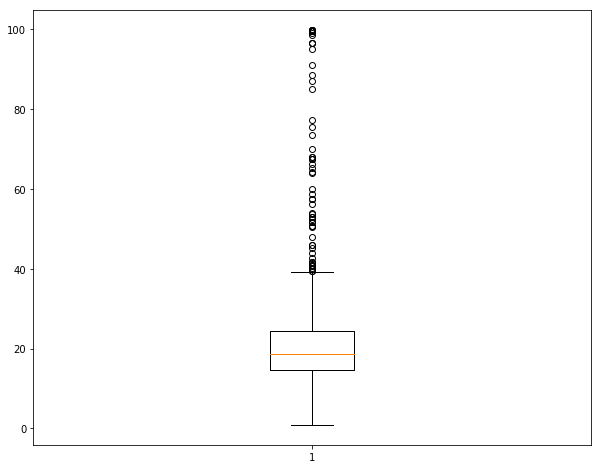

In [7]:
fig = plt.figure()
axs = plt.gca()
plt.boxplot(max_pothers)

305.0
token
39.0,467.0,630.0,196.0,24.0,10.0,9.0,9.0,4.0,1.0,4.0,4.0,16.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32.0,94.6666666667,157.333333333,220.0,282.666666667,345.333333333,408.0,470.666666667,533.333333333,596.0,658.666666667,721.333333333,784.0,846.666666667,909.333333333,972.0,1034.66666667,1097.33333333,1160.0,1222.66666667,1285.33333333,1348.0,1410.66666667,1473.33333333,1536.0,1598.66666667,1661.33333333,1724.0,1786.66666667,1849.33333333,1912.0
pother
1.0,6.0,46.0,140.0,240.0,277.0,247.0,183.0,108.0,50.0,21.0,12.0,8.0,3.0,2.0,9.0,2.0,3.0,0.0,20.0,6.0,0.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,24.0
1.26,4.54833333333,7.83666666667,11.125,14.4133333333,17.7016666667,20.99,24.2783333333,27.5666666667,30.855,34.1433333333,37.4316666667,40.72,44.0083333333,47.2966666667,50.585,53.8733333333,57.1616666667,60.45,63.7383333333,67.0266666667,70.315,73.6033333333,76.8916666667,80.18,83.4683333333,86.7566666667,90.045,93.3333333333,96.6216666667,99.91
39.7125
IQR f

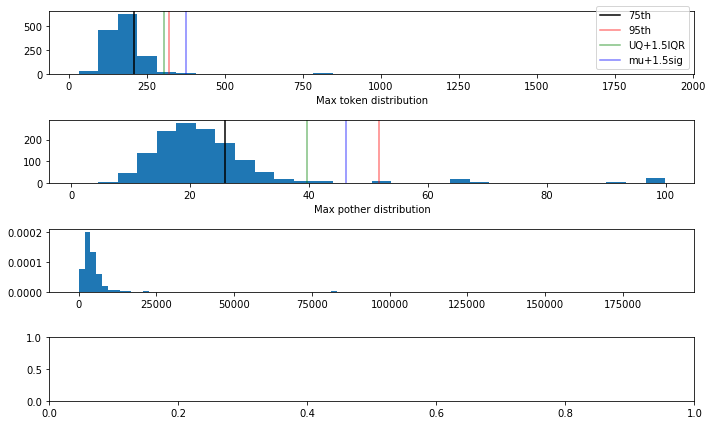

In [263]:


fig, axs = plt.subplots(4,1, figsize=(10, 6))
bin1 = axs[0].hist(max_tokens, bins=30)
axs[0].axvline(x=np.percentile(max_tokens, 75), c='k',label='75th')
axs[0].axvline(x=np.percentile(max_tokens, 95), c='r', alpha=0.5,label='95th')
print np.percentile(max_tokens, 75) + 1.5*(np.percentile(max_tokens,75) - np.percentile(max_tokens,25))
axs[0].axvline(x=np.percentile(max_tokens, 75) + 1.5*(np.percentile(max_tokens,75) - np.percentile(max_tokens,25)),c='g', alpha=0.5,label='UQ+1.5IQR')
axs[0].axvline(x=1.5*np.std(max_tokens)+np.mean(max_tokens), c='b', alpha=0.5,label='mu+1.5sig')
axs[0].set_xlabel('Max token distribution')
axs[0].legend()
bin2 = axs[1].hist(max_pothers, bins=30)
print "token"
print ','.join(map(str, bin1[0].tolist()))
print ','.join(map(str, bin1[1].tolist()))
print "pother"
print ','.join(map(str, bin2[0].tolist()))
print ','.join(map(str, bin2[1].tolist()))
#, bin1[1].tolist()
#print bin2[0].tolist(), bin2[1].tolist()
axs[1].axvline(x=np.percentile(max_pothers, 75), c='k',label='75th')
axs[1].axvline(x=np.percentile(max_pothers, 95), c='r', alpha=0.5,label='95th')
print np.percentile(max_pothers, 75) + 1.5*(np.percentile(max_pothers,75) - np.percentile(max_pothers,25))
axs[1].axvline(x=np.percentile(max_pothers, 75) + 1.5*(np.percentile(max_pothers,75) - np.percentile(max_pothers,25)),c='g', alpha=0.5,label='UQ+1.5IQR')
axs[1].axvline(x=1.5*np.std(max_pothers)+np.mean(max_pothers), c='b', alpha=0.5,label='mu+1.5sig')
axs[1].set_xlabel('Max pother distribution')
#axs[1].legend()
axs[2].hist(max_pothers*max_tokens, bins=100, normed=1)
fig.tight_layout()
IQR_factor = 1.5
coords_ell = get_ellipse_coords(max_tokens, max_pothers, factor=IQR_factor)
coords_abs = get_abs_coords(max_tokens, max_pothers, factor=IQR_factor)
print "ellipse:", coords_ell
print "abs:", coords_abs
save_ell_params(coords_ell, sim_dir=sim_dir)
save_abs_params(coords_abs,sim_dir=sim_dir)
#print '\n'.join(['%s,%s' % (max_pothers[i], max_tokens[i]) for i in range(len(max_pothers))])

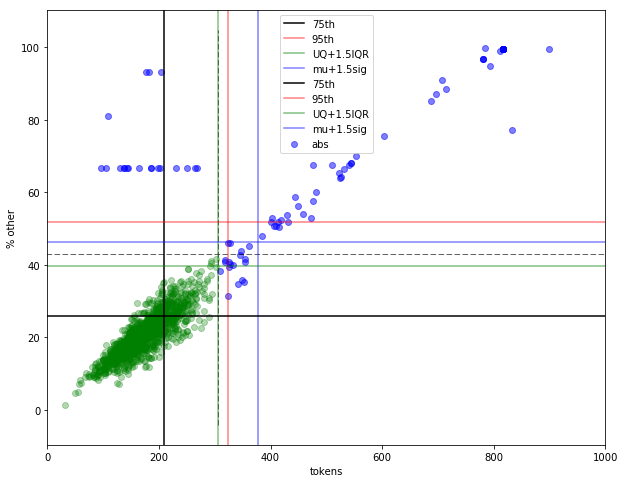

In [262]:
fig = plt.figure()
ax = plt.gca()
# for printing
# print '\n'.join(['%s\t%s' % (token, max_pother) for (token, max_pother) in zip(max_tokens, max_pothers)])
# graph
#graph_max_outliers_ell(max_tokens, max_pothers, ax, coords_ell)
graph_max_outliers_abs(max_tokens, max_pothers, ax, coords_abs)
#graph_max(max_tokens, max_pothers, ax)

# adjust axes
ax.legend(loc='upper left')
ax.set_ylabel('% other')
ax.set_xlabel('tokens')
ax.set_xlim([0, 1000])




ax.axvline(x=np.percentile(max_tokens, 75), c='k',label='75th')
ax.axvline(x=np.percentile(max_tokens, 95), c='r', alpha=0.5,label='95th')
ax.axvline(x=np.percentile(max_tokens, 75) + 1.5*(np.percentile(max_tokens,75) - np.percentile(max_tokens,25)),c='g', alpha=0.5,label='UQ+1.5IQR')
ax.axvline(x=1.5*np.std(max_tokens)+np.mean(max_tokens), c='b', alpha=0.5,label='mu+1.5sig')
ax.axhline(y=np.percentile(max_pothers, 75), c='k',label='75th')
ax.axhline(y=np.percentile(max_pothers, 95), c='r', alpha=0.5,label='95th')
ax.axhline(y=np.percentile(max_pothers, 75) + 1.5*(np.percentile(max_pothers,75) - np.percentile(max_pothers,25)),c='g', alpha=0.5,label='UQ+1.5IQR')
ax.axhline(y=1.5*np.std(max_pothers)+np.mean(max_pothers), c='b', alpha=0.5,label='mu+1.5sig')
ax.legend()


/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


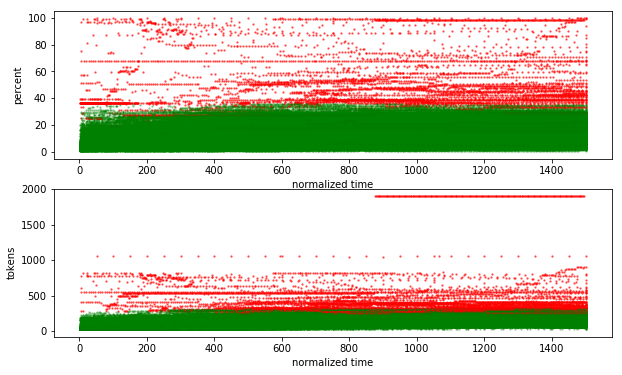

In [10]:
def plot_outliers_over_time(top_sims_arr, coords, axs, use_abs=False):
    alpha_out = 0.5
    c_in, alpha_in = 'g', 0.3
    outlier_fn = get_ellipse_outliers
    c_out = 'r'
    if use_abs:
        outlier_fn = get_abs_outliers
        c_out = 'b'

    for uname in top_sims_arr:
        x, ys = top_sims_arr[uname]
        x = np.array(x)
        pselfs, tokens, pothers = np.array(ys['pself']), np.array(ys['token']), np.array(ys['pother'])
        outliers, inliers = outlier_fn(tokens, pothers, coords)
        axs[0].scatter(x[outliers], pothers[outliers], c=c_out, alpha=alpha_out, s=2)
        axs[0].scatter(x[inliers], pothers[inliers], c=c_in, alpha=alpha_in, s=2)
        axs[1].scatter(x[outliers], tokens[outliers], c=c_out, alpha=alpha_out, s=2)
        axs[1].scatter(x[inliers], tokens[inliers], c=c_in, alpha=alpha_in, s=2)

fig, axs = plt.subplots(2,1, figsize=(10, 6))
plot_outliers_over_time(top_sims_arr, coords_ell, axs)
for ax in axs:
    ax.legend()

axs[0].set_ylabel('percent')
axs[1].set_ylabel('tokens')
axs[0].set_xlabel('normalized time')
axs[1].set_xlabel('normalized time')
plt.show()

## Save outliers

In [21]:
def get_and_save_outliers(year_q, use_abs=False, adjust=False):
    top_sims_yq = load_top_sims(year_q)
    if use_abs:
        coords = load_params('abs')
    else:
        coords = load_params('ell')
    field_ys = ['pself', 'pother', 'token', 'type_other']
    top_sims_arr_yq = top_sims_to_array(top_sims_yq, 'time', field_ys)
    outlier_dict_yq = get_outlier_stats(top_sims_arr_yq, coords, use_abs=use_abs, adjust=False)
    save_outliers(year_q, outlier_dict_yq)
    
print "Using adjusted slopes (divides tokens by two if needed)"
for year_q in year_qs:
    get_and_save_outliers(year_q, use_abs=True, adjust=False)
    
# note you should run python preprocess_online.py to find the necessary other + online graph

Using adjusted slopes (divides tokens by two if needed)
Wrote outliers to /Users/Lisa/Research/repos/socialTrajectory/top_sim_new/2012_1_outliers.csv
Wrote outliers to /Users/Lisa/Research/repos/socialTrajectory/top_sim_new/2013_1_outliers.csv
Wrote outliers to /Users/Lisa/Research/repos/socialTrajectory/top_sim_new/2014_1_outliers.csv
